<a href="https://colab.research.google.com/github/kaylay18/Fire-Prediction/blob/main/Forest_Fire_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import math
import pickle

# Load the dataset
file_name = '/content/wildfire_prediction_multi_output_dataset_v2.xlsx'  # Ensure this file is in the same directory as your script
df = pd.read_excel(file_name)

df.head()

,Temperature (°C),Humidity (%),Wind Speed (km/h),Rainfall (mm),Fuel Moisture (%),Vegetation Type,Slope (%),Region,Fire Size (hectares),Fire Duration (hours),Suppression Cost ($),Fire Occurrence
0,27.733250,89.108222,13.165364,44.032705,16.072075,Grassland,59.615524,South,442.648940,11.616707,491412.168125,Yes
1,28.789452,21.543283,37.853201,42.478192,25.176666,Forest,26.995937,South,17.689832,6.011346,422686.841282,No
2,30.256666,72.335215,19.592377,12.104919,22.251979,Shrubland,55.623107,South,256.142917,117.204594,169153.057914,Yes
3,17.856476,84.138818,5.448178,NaN,20.820927,Forest,3.944492,East,165.111292,38.125806,374758.030195,Yes
4,34.260178,62.698878,13.356131,27.465001,6.842731,Shrubland,54.280029,West,160.298123,15.668068,159537.710390,Yes


In [16]:
df_encoded = pd.get_dummies(df, columns=['Region','Vegetation Type', 'Fire Occurrence'])
df_encoded = df_encoded.astype(float)
df_encoded.head()

,Temperature (°C),Humidity (%),Wind Speed (km/h),Rainfall (mm),Fuel Moisture (%),Slope (%),Fire Size (hectares),Fire Duration (hours),Suppression Cost ($),Region_East,Region_North,Region_South,Region_West,Vegetation Type_Forest,Vegetation Type_Grassland,Vegetation Type_Shrubland,Fire Occurrence_No,Fire Occurrence_Yes
0,27.733250,89.108222,13.165364,44.032705,16.072075,59.615524,442.648940,11.616707,491412.168125,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,28.789452,21.543283,37.853201,42.478192,25.176666,26.995937,17.689832,6.011346,422686.841282,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,30.256666,72.335215,19.592377,12.104919,22.251979,55.623107,256.142917,117.204594,169153.057914,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,17.856476,84.138818,5.448178,NaN,20.820927,3.944492,165.111292,38.125806,374758.030195,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,34.260178,62.698878,13.356131,27.465001,6.842731,54.280029,160.298123,15.668068,159537.710390,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [17]:
df_encoded.fillna(0, inplace=True)
df_encoded.head()

,Temperature (°C),Humidity (%),Wind Speed (km/h),Rainfall (mm),Fuel Moisture (%),Slope (%),Fire Size (hectares),Fire Duration (hours),Suppression Cost ($),Region_East,Region_North,Region_South,Region_West,Vegetation Type_Forest,Vegetation Type_Grassland,Vegetation Type_Shrubland,Fire Occurrence_No,Fire Occurrence_Yes
0,27.733250,89.108222,13.165364,44.032705,16.072075,59.615524,442.648940,11.616707,491412.168125,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,28.789452,21.543283,37.853201,42.478192,25.176666,26.995937,17.689832,6.011346,422686.841282,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,30.256666,72.335215,19.592377,12.104919,22.251979,55.623107,256.142917,117.204594,169153.057914,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,17.856476,84.138818,5.448178,0.000000,20.820927,3.944492,165.111292,38.125806,374758.030195,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,34.260178,62.698878,13.356131,27.465001,6.842731,54.280029,160.298123,15.668068,159537.710390,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [18]:
# Calculate the IQR for each column
Q1 = df_encoded.quantile(0.25)
Q3 = df_encoded.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (df_encoded < (Q1 - 1.5 * IQR)) | (df_encoded > (Q3 + 1.5 * IQR))

# Remove outliers
df_no_outliers = df_encoded[~outliers.any(axis=1)]

In [19]:
df_encoded.describe()

,Temperature (°C),Humidity (%),Wind Speed (km/h),Rainfall (mm),Fuel Moisture (%),Slope (%),Fire Size (hectares),Fire Duration (hours),Suppression Cost ($),Region_East,Region_North,Region_South,Region_West,Vegetation Type_Forest,Vegetation Type_Grassland,Vegetation Type_Shrubland,Fire Occurrence_No,Fire Occurrence_Yes
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,29.050148,46.908724,19.139890,24.030537,21.384522,29.956677,250.422100,56.827527,236437.267658,0.24700,0.257800,0.247800,0.247400,0.333800,0.33740,0.328800,0.289200,0.710800
std,11.309404,25.048170,12.074482,15.111587,10.952618,17.301284,181.518144,36.414707,151386.694015,0.43131,0.437467,0.431778,0.431544,0.471616,0.47287,0.469824,0.453436,0.453436
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.015012,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,21.210858,26.157473,8.571929,10.954902,12.374043,14.850011,107.429909,25.068543,103690.258252,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,29.688475,46.790378,19.243462,23.927093,21.403734,29.899970,238.341551,56.283249,234521.343646,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
75%,37.475593,67.863280,29.861248,37.418938,30.678169,45.040702,374.935520,88.408864,368304.147487,0.00000,1.000000,0.000000,0.000000,1.000000,1.00000,1.000000,1.000000,1.000000
max,56.131937,89.974529,39.997698,49.999283,39.995114,59.989769,971.349463,119.994633,499980.374078,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


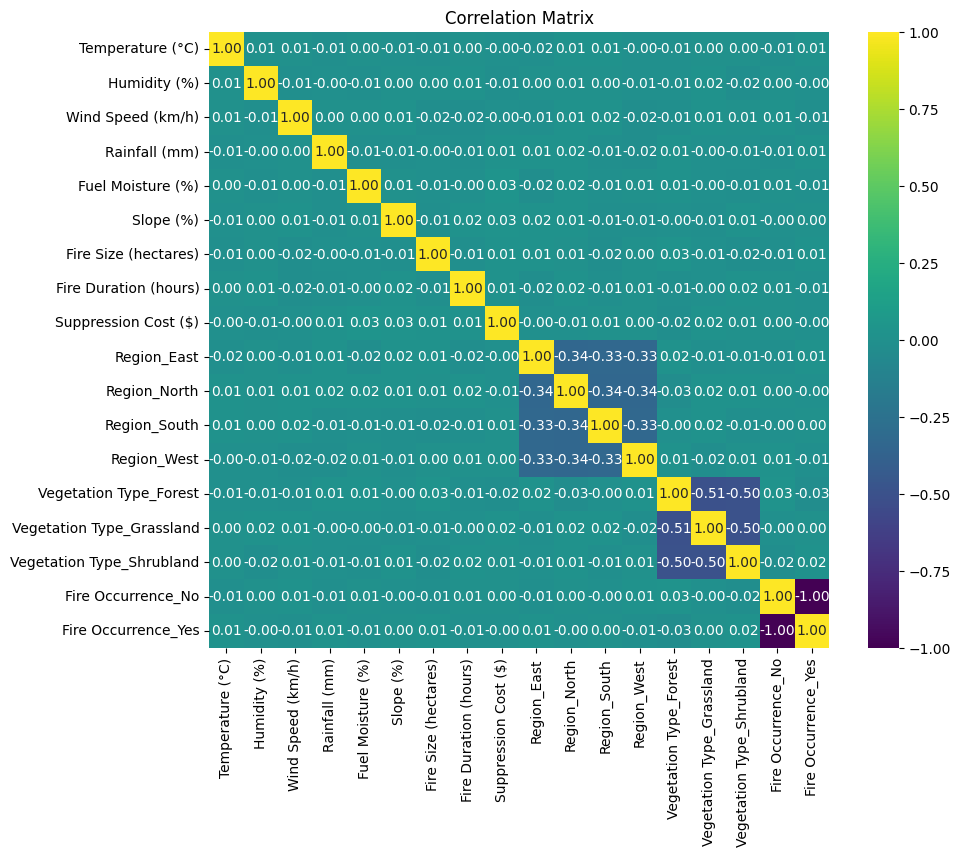

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [21]:
# Encode categorical variables
label_encoder = LabelEncoder()

# Apply label encoding to the target column (Label)
df['Fire Occurrence'] = label_encoder.fit_transform(df['Fire Occurrence'])

# Save the label encoder for future use
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [22]:
!pip install deon

In [23]:
# Generate the checklist using the Deon CLI in markdown format
!deon --output wildfire_ethics_checklist.md --format markdown

# Read and display the generated checklist
with open('wildfire_ethics_checklist.md', 'r') as file:
    checklist_content = file.read()

print(checklist_content)

# Customized Deon Ethics Checklist for Forest Wildfire Prediction Model

custom_checklist = """
# Ethics Checklist for Forest Wildfire Prediction Model

## 1. Data Collection
- **Input Variables**: Temperature, Humidity, Wind Speed, Rainfall, Fuel Moisture, Vegetation Type, Slope, Region
- **Output Variables**: Fire Size, Fire Duration, Suppression Cost, Fire Occurrence
- Are the data sources, such as weather, vegetation, and geographic data, properly licensed and legally available?
- Has any sensitive information, such as private property or personal location data, been anonymized?
- Have you obtained consent for data collected from private or proprietary sources, such as satellite imagery or drone footage?

## 2. Fairness & Justice
- How will you ensure that the model’s predictions are fair and do not disproportionately affect specific regions or communities (e.g., indigenous lands, rural areas)?
- What biases might exist in the historical data (e.g., underreporting of fires in certain regions), and how will you address these to ensure the model does not unfairly target or neglect specific areas?
- How will you balance fairness in handling both false positives (predicting a fire where there is none) and false negatives (failing to predict a fire)?
- Have you tested the model across different regions to ensure consistent performance across various forest types (tropical, temperate, etc.)?

## 3. Transparency
- How will you ensure transparency about the data sources, algorithms, and decision-making process of the model?
- What information will you make available to government agencies, the public, and environmental organizations?
- How will you communicate the model’s predictions and limitations to decision-makers so that they understand the risks involved?
- How will you explain false positives and false negatives to the affected communities or stakeholders, especially during critical events like evacuations?

## 4. Privacy
- How will you ensure the privacy of individuals whose data might be inadvertently captured (e.g., campers, rural residents) through satellite images, drones, or weather stations?
- What steps will you take to prevent the misuse of this data, especially in terms of tracking human activities in forest areas without their consent?
- If external data sources, such as drones or surveillance tools, are integrated into the model, how will you balance the need for accurate predictions with protecting individual privacy?

## 5. Accountability
- Who will be held accountable if the model incorrectly predicts a wildfire, resulting in unnecessary evacuations or failure to prevent a disaster?
- What system will you establish to monitor and adjust the model over time, ensuring it adapts to changing environmental and climate conditions?
- How will you communicate accountability measures to the public, especially in high-risk areas where wildfire prediction is critical?

## 6. Inclusivity
- How will you ensure the model includes diverse data from different types of forests (e.g., tropical, temperate) and regions, especially those that may be underrepresented in historical data collection?
- How will you ensure the model accounts for the needs of different communities, including vulnerable populations such as indigenous groups or rural residents who have unique relationships with the land?
- If certain regions or communities lack sufficient data (e.g., underreporting, lack of resources), how will you address this to avoid biased predictions?

## 7. Sustainability
- How will the model’s predictions affect long-term forestry practices, land management, and firefighting strategies over time?
- How will you ensure the model remains sustainable, considering the evolving nature of climate change and its effects on wildfire patterns?
- What are the broader social and environmental implications if this model becomes widely adopted (e.g., impacts on land use, deforestation policies, wildlife conservation)?
"""

# Save the customized checklist to a new markdown file
with open('custom_wildfire_ethics_checklist.md', 'w') as file:
    file.write(custom_checklist)

print("Custom ethics checklist saved as 'custom_wildfire_ethics_checklist.md'")

Checklist successfully written to file wildfire_ethics_checklist.md.
# Data Science Ethics Checklist

[![Deon badge](https://img.shields.io/badge/ethics%20checklist-deon-brightgreen.svg?style=popout-square)](http://deon.drivendata.org/)

## A. Data Collection
 - [ ] **A.1 Informed consent**: If there are human subjects, have they given informed consent, where subjects affirmatively opt-in and have a clear understanding of the data uses to which they consent?
 - [ ] **A.2 Collection bias**: Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?
 - [ ] **A.3 Limit PII exposure**: Have we considered ways to minimize exposure of personally identifiable information (PII) for example through anonymization or not collecting information that isn't relevant for analysis?
 - [ ] **A.4 Downstream bias mitigation**: Have we considered ways to enable testing downstream results for biased outcomes (e.g., collecting data

In [24]:
# Splitting the dataset into training and test sets
# Assuming 'Fire Occurrence' was one-hot encoded into columns like 'Fire Occurrence_0', 'Fire Occurrence_1', etc.
columns_to_drop = [col for col in df_encoded.columns if 'Fire Occurrence' in col]
X = df_encoded.drop(columns=columns_to_drop, axis=1)
y = df['Fire Occurrence']

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data (for certain models like SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Machine Learning Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

# Training and evaluating the models
best_model = None
best_rmse = float('inf')

for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Use scaled data for SVM, for others, use non-scaled data
    if model_name == "SVM":
        model.fit(X_train_scaled, y_train)
        y_test_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

    # Calculate RMSE for the test dataset
    rmse_test = math.sqrt(mean_squared_error(y_test, y_test_pred))

    # Save the best model based on RMSE for the test dataset
    if rmse_test < best_rmse:
        best_rmse = rmse_test
        best_model = model
        best_model_name = model_name

    print(f"{model_name} RMSE on Test Data: {rmse_test}")

# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model: {best_model_name} with RMSE: {best_rmse}")


Training Random Forest...
Random Forest RMSE on Test Data: 0.5540758070878027
Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression RMSE on Test Data: 0.5513619500836089
Training Decision Tree...
Decision Tree RMSE on Test Data: 0.6387487769068525
Training SVM...
SVM RMSE on Test Data: 0.5513619500836089
Best model: Logistic Regression with RMSE: 0.5513619500836089


In [25]:
!pip install streamlit
!pip show streamlit
import streamlit as st
import pandas as pd
import pickle

# Load the pre-trained model
@st.cache_resource
def load_model():
    with open('best_model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)
    return model

# Load the label encoder
@st.cache_resource
def load_label_encoder():
    with open('label_encoder.pkl', 'rb') as label_encoder_file:
        label_encoder = pickle.load(label_encoder_file)
    return label_encoder

# Load the model and encoder
model = load_model()
label_encoder = load_label_encoder()

# Title of the app
st.title("Forest Fire Prediction")

# Sidebar inputs for user preferences
st.sidebar.header("User Preferences")

temperature = st.number_input("Enter a temperature (C):", value=0)
humidity = st.number_input("Enter humidity percentage:", value=0)
wind_speed = st.number_input("Enter wind speed (km/h):", value=0)
rainfall = st.number_input("Enter rainfall amount (mm):", value=0)
fuel_moisture = st.number_input("Enter fuel moisture percentage:", value=0)
vegetation_type= st.sidebar.selectbox("Vegetation Type", ['grassland', 'forest', 'shrubland'])
slope = st.number_input("Enter slope percentage", value=0)
region = st.sidebar.selectbox("Region", ['North', 'South', 'East', 'West'])
fire_size = st.number_input("Enter fire size (hectares):", value=0)
fire_duration = st.number_input("Enter fire duration (hours):", value=0)
suppression_cost = st.number_input("Enter supression cost ($):", value=0)

# Encoding the inputs manually (same encoding as in your training data)
input_data = pd.DataFrame({
    'Temperature (°C)': [temperature],
    'Humidity (%)': [humidity],
    'Wind Speed (km/h)': [wind_speed],
    'Rainfall (mm)': [rainfall],
    'Fuel Moisture (%)': [fuel_moisture],
    'Vegetation Type': [vegetation_type],
    'Slope (%)': [slope],
    'Region': [region],
    'Fire Size (hectares)': [fire_size],
    'Fire Duration (hours)': [fire_duration],
    'Suppression Cost ($)': [suppression_cost]
})

# One-hot encode the input data (ensure it matches the training data)
input_encoded = pd.get_dummies(input_data)

# Align columns with the training data (required columns)
required_columns = model.feature_names_in_  # Get the feature columns from the model
for col in required_columns:
    if col not in input_encoded.columns:
        input_encoded[col] = 0
input_encoded = input_encoded[required_columns]

# Make the prediction
prediction = model.predict(input_encoded)[0]

# Reverse the label encoding (map the prediction back to the coffee type)
fire_occurance = label_encoder.inverse_transform([prediction])[0]

# Display the prediction
st.subheader(f"Fire occurance likely?: {fire_occurance}")

# Markdown content
md_content = """
# Ethics Checklist for Forest Wildfire Prediction Model

## 1. Data Collection
- **Input Variables**: Temperature, Humidity, Wind Speed, Rainfall, Fuel Moisture, Vegetation Type, Slope, Region
- **Output Variables**: Fire Size, Fire Duration, Suppression Cost, Fire Occurrence
- Are the data sources, such as weather, vegetation, and geographic data, properly licensed and legally available?
- Has any sensitive information, such as private property or personal location data, been anonymized?
- Have you obtained consent for data collected from private or proprietary sources, such as satellite imagery or drone footage?

## 2. Fairness & Justice
- How will you ensure that the model’s predictions are fair and do not disproportionately affect specific regions or communities (e.g., indigenous lands, rural areas)?
- What biases might exist in the historical data (e.g., underreporting of fires in certain regions), and how will you address these to ensure the model does not unfairly target or neglect specific areas?
- How will you balance fairness in handling both false positives (predicting a fire where there is none) and false negatives (failing to predict a fire)?
- Have you tested the model across different regions to ensure consistent performance across various forest types (tropical, temperate, etc.)?

## 3. Transparency
- How will you ensure transparency about the data sources, algorithms, and decision-making process of the model?
- What information will you make available to government agencies, the public, and environmental organizations?
- How will you communicate the model’s predictions and limitations to decision-makers so that they understand the risks involved?
- How will you explain false positives and false negatives to the affected communities or stakeholders, especially during critical events like evacuations?

## 4. Privacy
- How will you ensure the privacy of individuals whose data might be inadvertently captured (e.g., campers, rural residents) through satellite images, drones, or weather stations?
- What steps will you take to prevent the misuse of this data, especially in terms of tracking human activities in forest areas without their consent?
- If external data sources, such as drones or surveillance tools, are integrated into the model, how will you balance the need for accurate predictions with protecting individual privacy?

## 5. Accountability
- Who will be held accountable if the model incorrectly predicts a wildfire, resulting in unnecessary evacuations or failure to prevent a disaster?
- What system will you establish to monitor and adjust the model over time, ensuring it adapts to changing environmental and climate conditions?
- How will you communicate accountability measures to the public, especially in high-risk areas where wildfire prediction is critical?

## 6. Inclusivity
- How will you ensure the model includes diverse data from different types of forests (e.g., tropical, temperate) and regions, especially those that may be underrepresented in historical data collection?
- How will you ensure the model accounts for the needs of different communities, including vulnerable populations such as indigenous groups or rural residents who have unique relationships with the land?
- If certain regions or communities lack sufficient data (e.g., underreporting, lack of resources), how will you address this to avoid biased predictions?

## 7. Sustainability
- How will the model’s predictions affect long-term forestry practices, land management, and firefighting strategies over time?
- How will you ensure the model remains sustainable, considering the evolving nature of climate change and its effects on wildfire patterns?
- What are the broader social and environmental implications if this model becomes widely adopted (e.g., impacts on land use, deforestation policies, wildlife conservation)?
"""

st.markdown(md_content)

# Ethics DataCard content for forest wildfire prediction model
datacard_content = """
# Ethics DataCard for Forest Wildfire Prediction Model

## Dataset Overview
- **Input Variables**: Temperature, Humidity, Wind Speed, Rainfall, Fuel Moisture, Vegetation Type, Slope, Region
- **Output Variables**: Fire Size, Fire Duration, Suppression Cost, Fire Occurrence

## Data Collection Process
- Data sources include weather data, satellite imagery, vegetation reports, and topographical data.
- Data is collected from public and licensed sources, ensuring proper consent and anonymization of any private information (e.g., personal property location).

## Bias Considerations
- **Potential Bias**: Historical data may underreport wildfires in remote or underserved regions (e.g., rural or indigenous lands).
- **Mitigation**: The model is designed to minimize biases by cross-referencing multiple data sources and continuously monitoring the data collection process to ensure it includes diverse geographic regions.

## Fairness & Justice
- The model has been trained to predict wildfires across various geographic regions and forest types. Efforts have been made to avoid disproportionate impacts on vulnerable communities (e.g., rural populations, indigenous lands).
- Special attention is given to reducing false positives (unnecessary evacuations) and false negatives (failure to predict real wildfires), balancing the risk for all stakeholders.

## Privacy and Security
- Satellite data, weather station information, and geographic data are used, with efforts to anonymize any personal information inadvertently captured (e.g., campers, property owners).
- No social media or surveillance data is used without explicit consent.

## Sustainability and Environmental Impact
- The model aims to assist in sustainable land management and wildfire mitigation strategies by improving early prediction and reducing the severity of wildfires.
- It supports long-term environmental sustainability by informing decisions around land use, deforestation, and conservation practices.

## Model Limitations
- The model's accuracy may vary depending on the region and the quality of data available.
- There are limitations to predicting wildfires in regions with insufficient historical data, leading to potential inaccuracies.
- The model is regularly updated to incorporate new climate data and evolving environmental conditions.

## Accountability and Transparency
- The development team will monitor the model for performance over time, ensuring that it adapts to new data and environmental shifts.
- Stakeholders (e.g., firefighting agencies, local governments) will be informed of the model’s limitations, ensuring proper interpretation of the predictions.
- False predictions will be communicated to stakeholders, with a process in place for continuous feedback and model improvement.

## Societal Impact
- The model is designed to protect both human lives and the environment by enabling better planning and response to wildfire threats.
- It has the potential to inform policy changes in land management, conservation, and emergency response strategies.
"""
st.markdown(datacard_content)


Name: streamlit
Version: 1.39.0
Summary: A faster way to build and share data apps
Home-page: https://streamlit.io
Author: Snowflake Inc
Author-email: hello@streamlit.io
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: altair, blinker, cachetools, click, gitpython, numpy, packaging, pandas, pillow, protobuf, pyarrow, pydeck, requests, rich, tenacity, toml, tornado, typing-extensions, watchdog
Required-by: 


2024-10-22 17:05:48.471 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 17:05:48.478 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 17:05:48.481 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 17:05:48.493 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 17:05:48.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 17:05:48.501 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 17:05:48.511 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 17:05:48.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()